In this notebook I am testing netMHCpan and trying to find relationship between predicted affinity and MHC coverage

In [1]:
%matplotlib inline

import os
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
from scipy import stats

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
HLA_A0201 = pd.read_csv("output/netMHCpan/HLA-A02:01_NMP_9mer_proc.txt", sep=' ')
HLA_A0201.head()

,HLA,Peptide,Aff(nM)
0,HLA-A*02:01,AAAGLPGLA,16485.6
1,HLA-A*02:01,AAAGLPLAP,32838.8
2,HLA-A*02:01,AAAGLPSAS,32574.4
3,HLA-A*02:01,AAAGLQGRP,42398.3
4,HLA-A*02:01,AAAGLQRLA,23214.9


In [3]:
HLA_A0201[HLA_A0201["Aff(nM)"]<500]["Aff(nM)"].count()

337077

In [4]:
counts = []
for name in tqdm_notebook(os.listdir("output/netMHCpan/")):
    if "NMP" in name:
        df = pd.read_csv("output/netMHCpan/" + name, sep=' ')
        count = df[df["Aff(nM)"]<=500]["Aff(nM)"].count()
        counts.append((name.split("_")[0], count))
len(counts)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


82

In [5]:
cnts = pd.DataFrame(counts, index=range(len(counts)))
cnts.head()

,0,1
0,HLA-A68:01,334565
1,HLA-A03:01,150745
2,HLA-B18:01,72561
3,HLA-C07:02,113285
4,HLA-B73:01,6171


In [6]:
cnts = cnts.sort_values(by=1, ascending=False)
cnts.describe()

,1
count,82.000000
mean,190619.804878
std,183687.073389
min,269.000000
25%,49680.250000
50%,136005.500000
75%,292978.500000
max,815036.000000


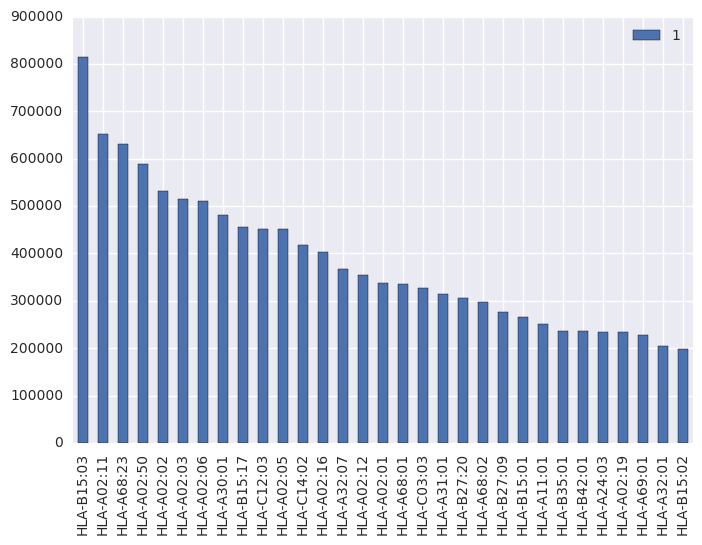

In [7]:
cnts.index = range(len(cnts))
ax = cnts.ix[:30,:].plot(kind="bar")
ax.set_xticklabels([str(i) for i in cnts.ix[:30,0]]);

In [8]:
cnts.head()

,0,1
0,HLA-B15:03,815036
1,HLA-A02:11,652613
2,HLA-A68:23,630471
3,HLA-A02:50,589291
4,HLA-A02:02,532413


In [9]:
cnts.tail()

,0,1
77,HLA-B46:01,3106
78,HLA-C04:01,453
79,HLA-B08:02,410
80,HLA-E01:01,285
81,HLA-B08:03,269


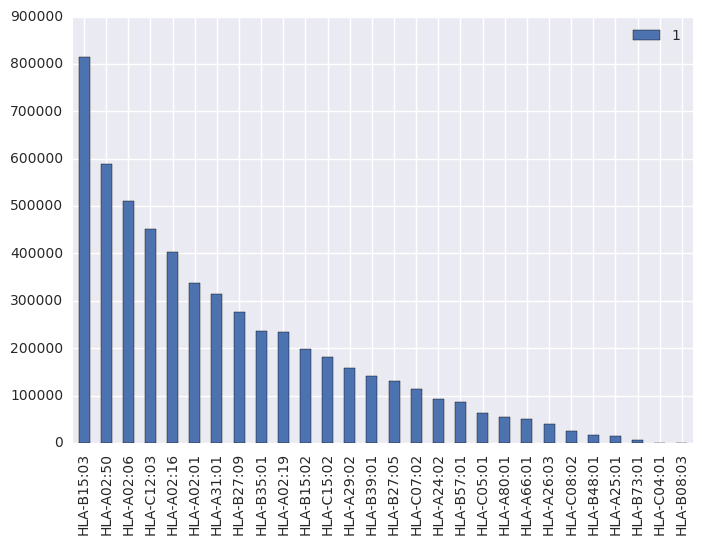

In [10]:
c = cnts.ix[range(0,len(cnts), 3),:]
c.index = range(len(c))
ax = c.plot(kind="bar")
ax.set_xticklabels([str(i) for i in c[0]]);

In [11]:
df = pd.read_csv("data/bdata.csv")
df = df[df['species']=='human']
df.head()

,species,mhc,peptide_length,cv,sequence,inequality,meas
9873,human,HLAA0101,8,TBD,AEMKTDAA,=,29766.651099
9874,human,HLAA0101,8,TBD,AFPTSCHM,>,70422.535211
9875,human,HLAA0101,8,TBD,AQFSPQYL,>,87719.298246
9876,human,HLAA0101,8,TBD,ASFCGSPY,=,51.400000
9877,human,HLAA0101,8,TBD,CCFHCQVC,>,87719.298246


In [12]:
freq = df.mhc.value_counts()
freq.head()

HLAA0201    11920
HLAA0301     7089
HLAA0203     6302
HLAA1101     6255
HLAA3101     5628
Name: mhc, dtype: int64

In [13]:
cnts[0] = cnts[0].str.replace(":", "")
cnts[0] = cnts[0].str.replace("-", "")
cnts.head()

,0,1
0,HLAB1503,815036
1,HLAA0211,652613
2,HLAA6823,630471
3,HLAA0250,589291
4,HLAA0202,532413


In [14]:
coverage = pd.DataFrame(freq.ix[cnts[0]])
coverage[0] = coverage.index
coverage.index = range(len(coverage))
coverage.head()

,mhc,0
0,701.0,HLAB1503
1,1085.0,HLAA0211
2,82.0,HLAA6823
3,135.0,HLAA0250
4,4155.0,HLAA0202


In [15]:
cnts['mhc'] = coverage['mhc']
cnts = cnts.dropna()
cnts.head()

,0,1,mhc
0,HLAB1503,815036,701.0
1,HLAA0211,652613,1085.0
2,HLAA6823,630471,82.0
3,HLAA0250,589291,135.0
4,HLAA0202,532413,4155.0


In [16]:
cn = pd.DataFrame()
cn['hla'] = cnts[0]
cn['affinity'] = cnts[1] / cnts[1].max()
cn['coverage'] = cnts['mhc'] / cnts['mhc'].max()
cn.head()

,hla,affinity,coverage
0,HLAB1503,1.000000,0.058809
1,HLAA0211,0.800717,0.091023
2,HLAA6823,0.773550,0.006879
3,HLAA0250,0.723025,0.011326
4,HLAA0202,0.653239,0.348574


In [17]:
cn.describe()

,affinity,coverage
count,80.000000,80.000000
mean,0.234650,0.156960
std,0.227107,0.178640
min,0.000330,0.000084
25%,0.058219,0.017659
50%,0.166871,0.093163
75%,0.367924,0.238968
max,1.000000,1.000000


In [18]:
stats.shapiro(cn.affinity), stats.shapiro(cn.coverage)

((0.8735053539276123, 1.0917267445620382e-06),
 (0.7977970838546753, 4.120859653511388e-09))

In [19]:
stats.pearsonr(cnts[1], cnts['mhc'])

(0.17367517731527124, 0.12339374999810965)

In [20]:
stats.pearsonr(cn['affinity'], cn['coverage'])

(0.17367517731527121, 0.12339374999810965)

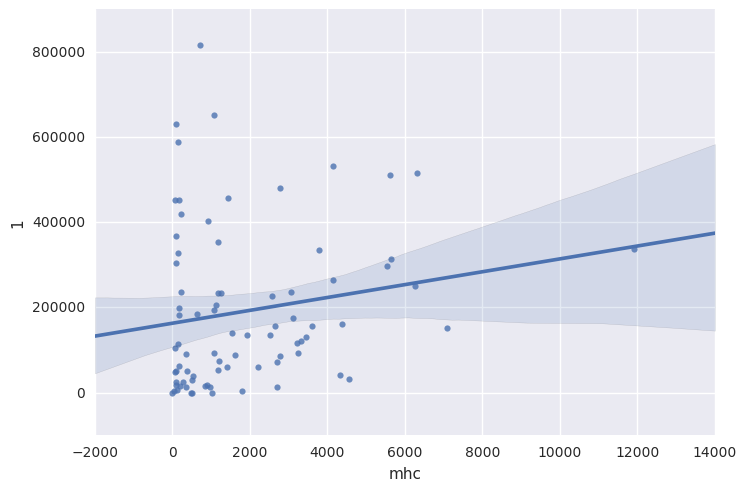

In [21]:
sns.regplot(data=cnts, x=cnts['mhc'],y=cnts[1])

/home/vcvetkov/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


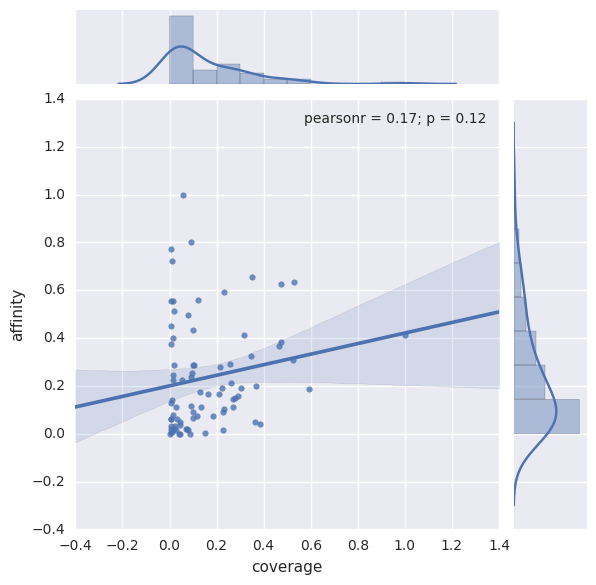

In [22]:
sns.jointplot(data=cn, x='coverage',y="affinity", kind="reg")